In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
import cmasher as cmr
plt.style.use('science')
import jax.random as random 
from matplotlib.patches import Ellipse

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

import JaxStreams

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
## Define a MW Potential Model
params_global_potential = {'m_disk':5.0e10, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0, }
pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                       b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

## Combine potentials
potential_list = [pot_disk,pot_NFW]
pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


## Gala equivalent
pot_gala_disk = gp.MiyamotoNagaiPotential(m=params_global_potential['m_disk'],a=params_global_potential['a_disk'],
                         b=params_global_potential['b_disk'],units=usys)

pot_gala_NFW = gp.NFWPotential(m=params_global_potential['m_NFW'],r_s=params_global_potential['r_s_NFW'],units=usys)

pot_gala = pot_gala_disk + pot_gala_NFW
H = gp.Hamiltonian(pot_gala)


In [11]:
## Integrate an orbit
t0 = 0.
dt = 0.5
n_steps = 8_000#8_000
w0 = jnp.array([30., 10., 20, (10*u.km/u.s).to(u.kpc/u.Myr).value, (-150*u.km/u.s).to(u.kpc/u.Myr).value, (-20*u.km/u.s).to(u.kpc/u.Myr).value])

ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
ws_jax = JaxStreams.leapfrog_run(w0, ts, pot.gradient)


w0_gala = gd.PhaseSpacePosition(pos=w0[:3].T*u.kpc,vel=w0[3:].T*u.kpc/u.Myr)
o_gala = H.integrate_orbit(w0=w0_gala,t=np.array(ts))

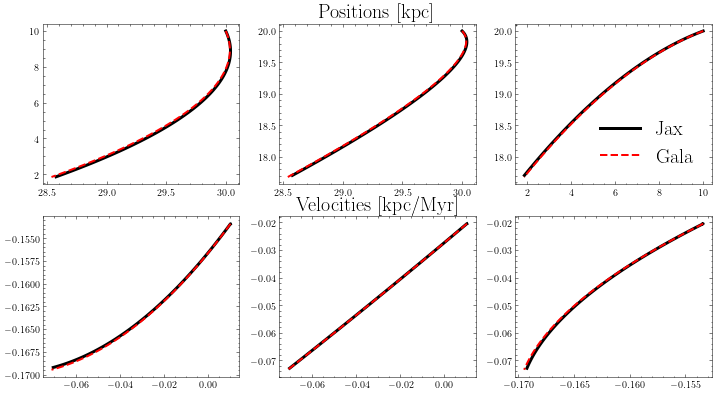

In [4]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6.5)
lw=3
ax[0,0].plot(ws_jax[:,0],ws_jax[:,1],color='k',lw=lw,rasterized=True)
ax[0,1].plot(ws_jax[:,0],ws_jax[:,2],color='k',lw=lw,rasterized=True)
ax[0,2].plot(ws_jax[:,1],ws_jax[:,2],color='k',lw=lw,rasterized=True,label='Jax')

ax[1,0].plot(ws_jax[:,3],ws_jax[:,4],color='k',lw=lw,rasterized=True)
ax[1,1].plot(ws_jax[:,3],ws_jax[:,5],color='k',lw=lw,rasterized=True)
ax[1,2].plot(ws_jax[:,4],ws_jax[:,5],color='k',lw=lw,rasterized=True)


ax[0,0].plot(o_gala.x,o_gala.y,color='r',ls='--',lw=2,rasterized=True)
ax[0,1].plot(o_gala.x,o_gala.z,color='r',ls='--',lw=2,rasterized=True)
ax[0,2].plot(o_gala.y,o_gala.z,color='r',ls='--',lw=2,rasterized=True,label='Gala')

ax[1,0].plot(o_gala.v_x,o_gala.v_y,color='r',ls='--',lw=2,rasterized=True)
ax[1,1].plot(o_gala.v_x,o_gala.v_z,color='r',ls='--',lw=2,rasterized=True)
ax[1,2].plot(o_gala.v_y,o_gala.v_z,color='r',ls='--',lw=2,rasterized=True)

ax[0,1].set_title('Positions [kpc]',fontsize=20)
ax[1,1].set_title('Velocities [kpc/Myr]',fontsize=20)

ax[0,2].legend(fontsize=20)
####plt.savefig('DiskNfw_JaxGalaOrbitInt.pdf',bbox_inches='tight')

In [12]:
## Now generate a mock stream along the above orbit
M_sat = 1.0e4 #progenitor mass

lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat, None, None)

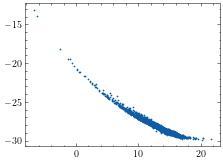

In [13]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.5,rasterized=True)

In [14]:
jax_stream_model = np.vstack([lead_arm,trail_arm])

In [8]:
## now in gala
from gala.dynamics import mockstream as ms
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
stream, prog = gen.run(w0_gala, prog_mass,
                        t=np.array(ts)*u.Myr,release_every=1,n_particles=1)


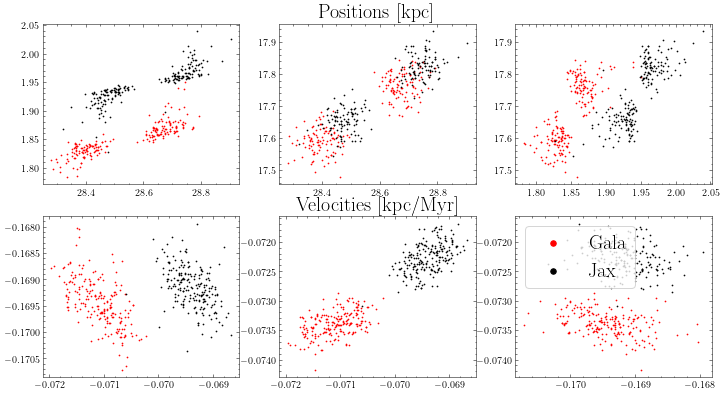

In [9]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6.5)
s=0.5
#ax[0,0].scatter(jax_stream_model[:,0],jax_stream_model[:,1],s=s,rasterized=True,color='k')
ax[0,0].scatter(stream.x,stream.y,s=0.5,rasterized=True,color='r')
ax[0,0].scatter(jax_stream_model[:,0],jax_stream_model[:,1],s=s,rasterized=True,color='k')

ax[0,1].scatter(stream.x,stream.z,s=0.5,rasterized=True,color='r')
ax[0,1].scatter(jax_stream_model[:,0],jax_stream_model[:,2],s=s,rasterized=True,color='k')

ax[0,2].scatter(stream.y,stream.z,s=0.5,rasterized=True,color='r',label='Gala')
ax[0,2].scatter(jax_stream_model[:,1],jax_stream_model[:,2],s=s,rasterized=True,color='k',label='Jax')


ax[1,0].scatter(stream.v_x,stream.v_y,s=0.5,rasterized=True,color='r')
ax[1,0].scatter(jax_stream_model[:,3],jax_stream_model[:,4],s=s,rasterized=True,color='k')

ax[1,1].scatter(stream.v_x,stream.v_z,s=0.5,rasterized=True,color='r')
ax[1,1].scatter(jax_stream_model[:,3],jax_stream_model[:,5],s=s,rasterized=True,color='k')

ax[1,2].scatter(stream.v_y,stream.v_z,s=0.5,rasterized=True,color='r',label='Gala')
ax[1,2].scatter(jax_stream_model[:,4],jax_stream_model[:,5],s=s,rasterized=True,color='k',label='Jax')


ax[0,1].set_title('Positions [kpc]',fontsize=20)
ax[1,1].set_title('Velocities [kpc/Myr]',fontsize=20)

lgnd=ax[1,2].legend(fontsize=20,frameon=True)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
##plt.savefig('DiskSphericalNFW_jax_Gala_Stream.pdf',bbox_inches='tight')

In [15]:
lead_arm_obs, trail_arm_obs = pot.gen_stream_final(ts, w0, M_sat, None, None)

In [17]:
lead_arm_obs.shape

(8000, 6)

In [18]:
def stream_gradients_kde(params,):
    @jax.jit
    def gradient_fn(params):
        ## Define a MW Potential Model
        pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                               b=params['b_disk'],units=usys)
        pot_NFW = JaxStreams.NFWPotential(m=params['m_NFW'], r_s=params['r_s_NFW'],units=usys)

        ## Combine potentials
        potential_list = [pot_disk,pot_NFW]
        pot_with_params = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)

        lead_arm, trail_arm = pot_with_params.gen_stream_final(ts, w0, M_sat, None, None)
        return -jnp.sum( (lead_arm-lead_arm_obs)**2 + (trail_arm-trail_arm_obs)**2 )
    # Compute the gradient using JAX's autodiff
    #################gradient_eval = jax.jacfwd(gradient_fn)(params)
    
    #grad_eval_func = lambda params: jax.jacfwd(gradient_fn)(params)
    #second_grad_eval = jax.jacfwd(grad_eval_func)(params)
    
    
    second_grad_eval = jax.jacfwd(jax.jacfwd(gradient_fn))(params)
    return None, second_grad_eval
    

    


In [19]:
gradient_eval, second_gradient = stream_gradients_kde(params_global_potential)


In [22]:
second_gradient['a_disk']

{'a_disk': Array(-960809.93865192, dtype=float64),
 'b_disk': Array(-60130.04079099, dtype=float64),
 'm_NFW': Array(5.04852062e-05, dtype=float64),
 'm_disk': Array(0.00018494, dtype=float64),
 'r_s_NFW': Array(-4242788.31080788, dtype=float64)}

In [23]:
second_gradient['m_disk']

{'a_disk': Array(0.00018494, dtype=float64),
 'b_disk': Array(2.18070099e-05, dtype=float64),
 'm_NFW': Array(-1.632562e-14, dtype=float64),
 'm_disk': Array(-6.32118524e-14, dtype=float64),
 'r_s_NFW': Array(0.00133388, dtype=float64)}